In [1]:
# Basic Packages
import numpy as np
import h5py
import logging
import os
import shutil
import gc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress, pearsonr, spearmanr
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats
import math
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
import pickle
import random
# Physics-related Packages
from astropy.cosmology import Planck15
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
import astropy.units as u
from scipy.optimize import root_scalar
from sklearn.inspection import permutation_importance

In [ ]:
# preparations for read box info from the url
import requests
import time

baseUrl = 'http://www.tng-project.org/api/'

def get(path, params=None, max_retries=5, backoff_factor=2):
    # make HTTP GET request to path
    headers = {"api-key":"API KEY"}

    attempt = 0
    while attempt < max_retries:
        try:
            r = requests.get(path, params=params, headers=headers)
            r.raise_for_status()

            if r.headers['content-type'] == 'application/json':
                return r.json()
            
            if 'content-disposition' in r.headers:
                filename = r.headers['content-disposition'].split("filename=")[1]
                with open(filename, 'wb') as f:
                    f.write(r.content)
                return filename
            return r  # fallback
        
        except Exception as e:
            attempt += 1
            wait = backoff_factor ** attempt
            print(f"[Retry {attempt}/{max_retries}] Request failed: {e}. Retrying in {wait}s...")
            time.sleep(wait)

    raise RuntimeError(f"Failed to GET {path} after {max_retries} retries.")

In [3]:
# Issue a request to the API root
r = get(baseUrl)

# Print out all the simulation names
names = [sim['name'] for sim in r['simulations']]
# Get the index of TNG300-1
i = names.index('TNG-Cluster')
# Get the info of simulation Illustris-3
sim = get( r['simulations'][i]['url'] )
sim.keys()

# get the snaps info this simulation
snaps = get(sim['snapshots'])

In [4]:
def find_redshift_from_lookback_time(tau_gyr):
    """
    Given a look back time, return the redshift
    """

    if tau_gyr >= Planck15.lookback_time(0.01).value:
        tau = tau_gyr * u.Gyr


        def f(z):
            return (Planck15.lookback_time(z) - tau).value  


        result = root_scalar(f, bracket=[0.01, 20], method='brentq')
        
        if result.converged:
            return result.root
        else:
            raise RuntimeError("Root finding failed for tau = {:.2f} Gyr".format(tau_gyr))
    
    else:
        return 0.


In [5]:
snap_numbers = np.zeros(len(snaps))
snap_redshifts = np.zeros(len(snaps))
for i, snap in enumerate(snaps):
    snap_numbers[i] = snap['number']
    snap_redshifts[i] = snap['redshift']

def find_nearest_snap(z):
    delta_z = np.abs(snap_redshifts - z)
    target_snap = snap_numbers[np.argmin(delta_z)]
    return int(target_snap)

In [6]:
def convert_feats_labels_to_training_set_snapcut_tv(feats_labels_dict, snap_cut, tau):
    feature_vectors = []
    label_scores = []
    label_scores_pre = []
    meta_info = []  

    for halo_id in feats_labels_dict:
        # print(halo_id)
        for snap in feats_labels_dict[halo_id]:
            projections = ['xy', 'blank', 'yz', 'blank', 'xz', 'blank']
            #projections = ['yz', 'blank', 'xz', 'blank', 'xy', 'blank']
            index = np.mod(snap-72,6)
            proj = projections[index]
            if proj == 'blank':
                continue
            if snap <= snap_cut:
                # print(halo_id,'*',snap)
                Redshift = snaps[snap]['redshift'] 
                h_at0 = Planck15.h
                scale = 1 / (h_at0 * (1 + Redshift))
                
                if f'label_score_all_tau{tau}' not in feats_labels_dict[halo_id][snap]:
                    print(f'label_scores_tau{tau} for halo {halo_id} and snap {snap}','vansish')
                    continue
                label = feats_labels_dict[halo_id][snap][f'label_score_all_tau{tau}']
                label_pre = feats_labels_dict[halo_id][snap][f'label_score_pre_tau{tau}']
                #print(snap)
                projections = feats_labels_dict[halo_id][snap]['features']
                

                feats = projections[proj]

                # Convert dict values to a fixed-order feature vector
                vec = [
                    #(feats['mean_r_0'] - feats['mean_r_1']) * scale, #0
                    #feats['mean_v_0'], #1
                    #feats['mean_v_1'], #2
                    np.abs(feats['mean_v_0']-feats['mean_v_1']), #3
                    feats['std_r_0'] * scale, #4
                    feats['std_r_1'] * scale, #5
                    feats['std_v_0'], #6
                    feats['std_v_1'], #7
                    #min(feats['n0'], feats['n1'])/max(feats['n0'], feats['n1']), #8
                    feats['bic_1'], #9
                    feats['bic_2'], #10
                    feats['bic_2'] - feats['bic_1'] - 6*np.log(feats['n0']+ feats['n1']), #11
                    feats['elongation_ratio'],  # 12
                    feats_labels_dict[halo_id][snap]['redshift'], #13
                    feats_labels_dict[halo_id][snap]['mass_ratio'], #14
                    feats['std_r'] * scale, #15
                    feats['std_v'], #16
                ]
                #print(feats['n0']+ feats['n1'])
                feature_vectors.append(vec)
                label_scores.append(label)
                label_scores_pre.append(label_pre)
                meta_info.append((halo_id, snap, proj))

    return np.array(feature_vectors), np.array(label_scores), np.array(label_scores_pre), meta_info

In [ ]:
def get_feats_label(snapcut, tau):
    with open('/users_path/merger_trace/data/tng_cluster/tng_cluster_products/feats_labels_dict_tngcluster.pkl', 'rb') as f:
        feats_labels_dict = pickle.load(f)

    feature_vectors, label_scores, label_scores_pre, meta_info = convert_feats_labels_to_training_set_snapcut_tv(feats_labels_dict, snapcut, tau)

    return feature_vectors, label_scores, label_scores_pre, meta_info

In [8]:
def XGboost_singletau_premerger_allmerger(tau, state = 'pre_merger', random_state = 42):
    if state == 'pre_merger':
        snapcut  = 100
        feature_vectors, label_scores, label_scores_pre, meta_info = get_feats_label(snapcut, tau)
        label_score_usedfor = label_scores_pre

    elif state == 'all_merger':
        cut_z = find_redshift_from_lookback_time(tau)
        snapcut = find_nearest_snap(cut_z)
        feature_vectors, label_scores, label_scores_pre, meta_info = get_feats_label(snapcut, tau)
        label_score_usedfor = label_scores

    
    elif state == 'post_merger':
        cut_z = find_redshift_from_lookback_time(tau)
        snapcut = find_nearest_snap(cut_z)
        feature_vectors, label_scores, label_scores_pre, meta_info = get_feats_label(snapcut, tau)
        label_score_usedfor = label_scores-label_scores_pre
    
    else:
        print('Please choose the right version of label scores')
    
    mask = np.where((label_score_usedfor >= 0 )& (label_score_usedfor <=20))[0].astype(int)

    # grouping data
    groups = [f"{hid}_{snap}" for (hid, snap, proj) in np.array(meta_info)[mask]]
    n_samples = len(feature_vectors[mask])
    assert len(label_score_usedfor[mask]) == n_samples == len(groups)

    # split training data and test data
    X = np.arange(len(groups))
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, label_score_usedfor[mask], groups=groups))

    X_train, X_test = feature_vectors[mask][train_idx], feature_vectors[mask][test_idx]
    y_train, y_test = label_score_usedfor[mask][train_idx], label_score_usedfor[mask][test_idx]
    group_train = np.array(groups)[train_idx]  # for GridSearchCV

    # set search grid for hyper parameters
    param_grid = {
    'learning_rate': [0.005,0.01,0.05, 0.1, 0.2],
    'max_depth': [1, 2, 4, 6, 8, 10],
    'n_estimators': [100, 200, 300, 500, 1000],
    }

    #initialize model and grid search
    model = XGBRegressor(random_state=random_state)
    cv_splitter = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=random_state)

    grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',
    cv=cv_splitter,
    n_jobs=-1,
    verbose=1
    )

    grid.fit(X_train, y_train, groups=group_train)

    # predict using best model 

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Best Params: {grid.best_params_}")
    print(f"XGBoost MSE: {mse:.4f}")
    print(f"XGBoost R²: {r2:.4f}")

    # visualize data
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', linewidths=0.3)
    plt.plot([0, 5], [0, 5], 'r--', label='Perfect Prediction')
    plt.xlabel('True Merger Score')
    plt.ylabel('Predicted Merger Score')
    plt.title('XGBoost: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    y_train_pred = best_model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    print(f"Training R²: {r2_train:.4f}")
    print(f"Training MSE: {mse_train:.4f}")

    feature_names = [
    #'delta_r_scaled', 'mean_v_0', 'mean_v_1', 
    'delta_v_abs',
    'std_r_0', 'std_r_1', 'std_v_0', 'std_v_1',
    #'number_ratio', 
    'bic_1', 'bic_2', 'bic_penalized_diff',
    'elongation_ratio', 'redshift', 'mass_ratio', 'std_r', 'std_v'
    ]


    # ==== Permutation importance ====
    from sklearn.inspection import permutation_importance

    print("\n--- Computing Permutation Importance ---")
    perm_result = permutation_importance(
        best_model, X_test, y_test, n_repeats=10, random_state=random_state, n_jobs=-1
    )

    perm_sorted_idx = np.argsort(perm_result.importances_mean)[::-1]
    plt.figure(figsize=(6.5, 4.5))
    plt.bar(range(len(perm_sorted_idx)), perm_result.importances_mean[perm_sorted_idx], color="#d95f02")
    plt.axhline(0.01, linestyle='--', color='red', linewidth=1.5)
    plt.xticks(range(len(perm_sorted_idx)), np.array(feature_names)[perm_sorted_idx], rotation=45, ha="right", fontsize=10)
    plt.ylabel("Permutation Importance", fontsize=12)
    plt.title("XGBoost Permutation Importance", fontsize=13)
    plt.tight_layout()
    plt.show()

    return (mse, r2, mse_train, r2_train, n_samples, y_test, y_pred, label_score_usedfor[mask],
            perm_result.importances_mean, perm_result.importances_std, feature_names)

label_scores_tau2.0 for halo 476245 and snap 80 vansish
label_scores_tau2.0 for halo 8714627 and snap 74 vansish
label_scores_tau2.0 for halo 10612178 and snap 78 vansish
label_scores_tau2.0 for halo 11484512 and snap 76 vansish
label_scores_tau2.0 for halo 18057470 and snap 76 vansish
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
XGBoost MSE: 0.7112
XGBoost R²: 0.4442


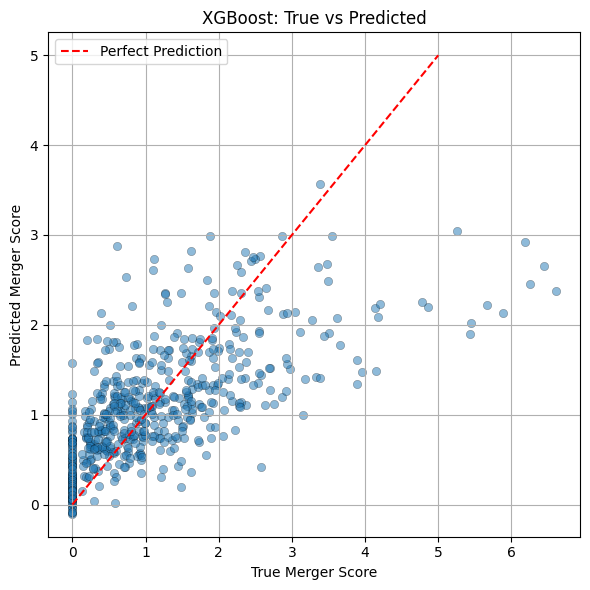

Training R²: 0.5118
Training MSE: 0.5314

--- Computing Permutation Importance ---


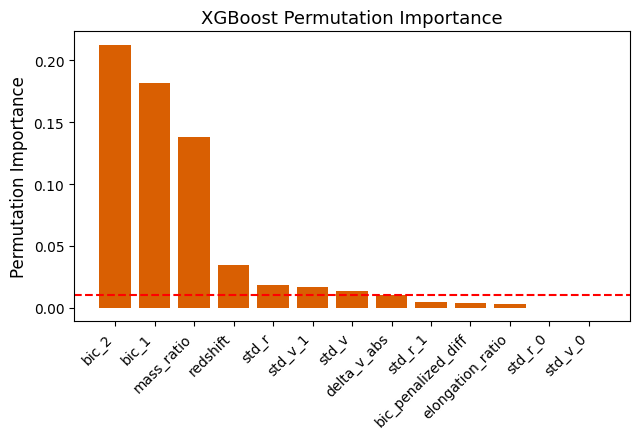

In [ ]:
tau = round(2.0, 1)
random_state = 2025
mse, r2, mse_train, r2_train, n_samples, y_test, y_pred, score_distribution, importances_mean, importances_std, feature_names = XGboost_singletau_premerger_allmerger(tau, state = 'post_merger', random_state = random_state)

In [16]:
importances_mean

array([ 0.01025338, -0.00021826,  0.00469099, -0.00025228,  0.01643947,
        0.18197806,  0.21274294,  0.0037327 ,  0.00329454,  0.03487618,
        0.13802498,  0.0185076 ,  0.01339189])

In [10]:

import numpy as np

np.savez("scatter_rotate_pruned_tau2.0_postmerger.npz", y_test=y_test, y_pred=y_pred)

